In [1]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np
import random
from random import shuffle
import datetime
import csv
import keras
import os

Using TensorFlow backend.


In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Data Loading

In [4]:
batch_size = 64
epochs = 400  
latent_dim = 10
num_samples = 45133

# This flag should be set to 1 for the classification style training
# Classification based task is when the network is expected to output
# 's' for the input 'apple' and 'es' for 'torch'.
# When the classfication flag is set to 0 then the network is expected to 
# output 'apples' for input 'apple' and 'torches' for input 'torch'. 
classification_flag = 1

# Path to the data txt file on disk.
data_path = './all_data.csv'

In [5]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [6]:
random.seed(0)
indices = np.array([i for i in range(len(input_texts))])
random.shuffle(indices)
input_texts = [input_texts[i] for i in indices]
target_texts = [target_texts[i] for i in indices]


In [7]:
print(indices)

[28441 19622 25667 ...,  2653 27562 25247]


In [8]:
s_words = []
es_words = []
ies_words = []
others = []
for i in range(len(input_texts)):
    input_sample = input_texts[i]
    output_sample = target_texts[i][1:-1]

    if (input_sample[-2:] == 'ch' or input_sample[-2:] == 'sh' or input_sample[-1:] == 'x' or \
        input_sample[-1:] == 's' or input_sample[-1:] == 'z') and output_sample[-2:] == 'es':
        es_words.append(i)
        if classification_flag:
            target_texts[i] = '\tes\n'
    elif input_sample[-1:] == 'y' and output_sample[-3:] == 'ies':
        ies_words.append(i)
        if classification_flag:
            target_texts[i] = '\ties\n'
    elif output_sample[-1:] == 's':
        s_words.append(i)
        if classification_flag:
            target_texts[i] = '\ts\n'
    else:
        others.append(i)
        if classification_flag:
            target_texts[i] = '\t\n'

            
print("Number of s_words: ", len(s_words))
print("Number of es_words: ", len(es_words))
print("Number of ies_words: ", len(ies_words))
print("Number of other_words: ", len(others))
print("Total words: ", len(s_words) + len(es_words) + len(ies_words) + len(others))

Number of s_words:  37862
Number of es_words:  3297
Number of ies_words:  3457
Number of other_words:  517
Total words:  45133


In [8]:
target_texts

['\tspeedups\n',
 '\trhizopogons\n',
 '\tindorsements\n',
 '\tpajamas\n',
 '\tmicrometries\n',
 '\tnews\n',
 '\tnagas\n',
 '\tschnappss\n',
 '\tcompassionates\n',
 '\toesophagitis\n',
 '\tjibs\n',
 '\tmacambas\n',
 '\tetherises\n',
 '\treflations\n',
 '\ttwirls\n',
 '\thaydns\n',
 '\tmomotuss\n',
 '\tcestidaes\n',
 '\tkennewicks\n',
 '\tsinclairs\n',
 '\tpackagings\n',
 '\tberserkers\n',
 '\tadrss\n',
 '\tcharacins\n',
 '\tpenalties\n',
 '\tsynthesizers\n',
 '\ttransfigurations\n',
 '\thalakas\n',
 '\tzitis\n',
 '\texcavates\n',
 '\tmontezs\n',
 '\tdevilries\n',
 '\tjingoists\n',
 '\tprotoes\n',
 '\tprofundities\n',
 '\tdichotomisations\n',
 '\tbesseras\n',
 '\tcrowberries\n',
 '\twhitewaters\n',
 '\teffeminises\n',
 '\tdiscoverers\n',
 '\tcordays\n',
 '\tsarahs\n',
 '\thubriss\n',
 '\tmushes\n',
 '\trothkoes\n',
 '\teiders\n',
 '\tfibs\n',
 '\tperjuries\n',
 '\tintuitionists\n',
 '\theavens\n',
 '\tiwoes\n',
 '\ttriavils\n',
 '\trusticates\n',
 '\tstarches\n',
 '\tperniss\n',
 '\tcowl

In [9]:
total = 3500
s_words = s_words[0:total]
es_words.extend(es_words[0:total - len(es_words)])

In [10]:
# Augmenting ies words as a way of weighted sampling
ies_words.extend(ies_words[0:total - len(ies_words)])

In [11]:
others = others[0:500]

In [12]:
print("Number of s_words: ", len(s_words))
print("Number of es_words: ", len(es_words))
print("Number of ies_words: ", len(ies_words))
print("Number of other_words: ", len(others))
print("Total words: ", len(s_words) + len(es_words) + len(ies_words) + len(others))

Number of s_words:  3500
Number of es_words:  3500
Number of ies_words:  3500
Number of other_words:  500
Total words:  11000


In [13]:
train_length = 3150
train_indices = s_words[0:train_length] + es_words[0:train_length] + ies_words[0:train_length] + others[0:450]
test_indices = s_words[train_length:] + es_words[train_length:] + ies_words[train_length:] + others[450:]
random.seed(1)
random.shuffle(train_indices)
random.shuffle(test_indices)

train_input = [input_texts[i] for i in train_indices]
train_output = [target_texts[i] for i in train_indices]

test_input = [input_texts[i] for i in test_indices]
test_output = [target_texts[i] for i in test_indices]

In [14]:
os.system("rm train.csv")
with open('train.csv', 'w', newline='\n') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for i in range(len(train_input)):
#         print("Input: ", train_input[i], "Output: ", train_output[i])
        writer.writerow([train_input[i], train_output[i]])

In [15]:
os.system("rm test.csv")
with open('test.csv', 'w', newline='\n') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for i in range(len(test_input)):
#         print("Input: ", test_input[i], "Output: ", test_output[i])
        writer.writerow([test_input[i], test_output[i]])

In [9]:
train_input = []
train_output = []
with open('train_ending.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        train_input.append(row[0])
        train_output.append(row[1]) # replace with row[1][1:-1] if you don't want \t and \n around the word
        
        

In [10]:
test_input = []
test_output = []
with open('test_ending.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        test_input.append(row[0])
        test_output.append(row[1]) # replace with row[1][1:-1] if you don't want \t and \n around the word

In [11]:
# Check for the count in train dataset
s_words = []
es_words = []
ies_words = []
others = []
for i in range(len(train_input)):
    input_sample = train_input[i]
    output_sample = train_output[i][1:-1]

    if (input_sample[-2:] == 'ch' or input_sample[-2:] == 'sh' or input_sample[-1:] == 'x' or \
        input_sample[-1:] == 's' or input_sample[-1:] == 'z') and output_sample[-2:] == 'es':
        es_words.append(i)
        if classification_flag:
            target_texts[i] = '\tes\n'
    elif input_sample[-1:] == 'y' and output_sample[-3:] == 'ies':
        ies_words.append(i)
        if classification_flag:
            target_texts[i] = '\ties\n'
    elif output_sample[-1:] == 's':
        s_words.append(i)
        if classification_flag:
            target_texts[i] = '\ts\n'
    else:
        others.append(i)
        if classification_flag:
            target_texts[i] = '\t\n'

print("Number of s_words: ", len(s_words))
print("Number of es_words: ", len(es_words))
print("Number of ies_words: ", len(ies_words))
print("Number of other_words: ", len(others))
print("Total words: ", len(s_words) + len(es_words) + len(ies_words) + len(others))

Number of s_words:  3150
Number of es_words:  3150
Number of ies_words:  3150
Number of other_words:  450
Total words:  9900


In [12]:
# Check for the count in train dataset
s_words = []
es_words = []
ies_words = []
others = []
for i in range(len(test_input)):
    input_sample = test_input[i]
    output_sample = test_output[i][1:-1]

    if (input_sample[-2:] == 'ch' or input_sample[-2:] == 'sh' or input_sample[-1:] == 'x' or \
        input_sample[-1:] == 's' or input_sample[-1:] == 'z') and output_sample[-2:] == 'es':
        es_words.append(i)
        if classification_flag:
            target_texts[i] = '\tes\n'
    elif input_sample[-1:] == 'y' and output_sample[-3:] == 'ies':
        ies_words.append(i)
        if classification_flag:
            target_texts[i] = '\ties\n'
    elif output_sample[-1:] == 's':
        s_words.append(i)
        if classification_flag:
            target_texts[i] = '\ts\n'
    else:
        others.append(i)
        if classification_flag:
            target_texts[i] = '\t\n'

print("Number of s_words: ", len(s_words))
print("Number of es_words: ", len(es_words))
print("Number of ies_words: ", len(ies_words))
print("Number of other_words: ", len(others))
print("Total words: ", len(s_words) + len(es_words) + len(ies_words) + len(others))

Number of s_words:  350
Number of es_words:  350
Number of ies_words:  350
Number of other_words:  50
Total words:  1100


In [13]:
# Check for the count in test dataset
s_words = []
es_words = []
ies_words = []
others = []
for i in range(len(test_input)):
    input_sample = test_input[i]
    output_sample = test_output[i][1:-1]

    if (input_sample[-2:] == 'ch' or input_sample[-2:] == 'sh' or input_sample[-1:] == 'x' or \
        input_sample[-1:] == 's' or input_sample[-1:] == 'z') and output_sample[-2:] == 'es':
        es_words.append(i)
        if classification_flag:
            target_texts[i] = '\tes\n'
    elif input_sample[-1:] == 'y' and output_sample[-3:] == 'ies':
        ies_words.append(i)
        if classification_flag:
            target_texts[i] = '\ties\n'
    elif output_sample[-1:] == 's':
        s_words.append(i)
        if classification_flag:
            target_texts[i] = '\ts\n'
    else:
        others.append(i)
        if classification_flag:
            target_texts[i] = '\t\n'

print("Number of s_words: ", len(s_words))
print("Number of es_words: ", len(es_words))
print("Number of ies_words: ", len(ies_words))
print("Number of other_words: ", len(others))
print("Total words: ", len(s_words) + len(es_words) + len(ies_words) + len(others))

Number of s_words:  350
Number of es_words:  350
Number of ies_words:  350
Number of other_words:  50
Total words:  1100


In [14]:
print("Number of samples in training set input: ", len(train_input))
print("Number of samples in training set output: ", len(train_output))
print("Number of samples in testing set input: ", len(test_input))
print("Number of samples in testing set output: ", len(test_output))

Number of samples in training set input:  9900
Number of samples in training set output:  9900
Number of samples in testing set input:  1100
Number of samples in testing set output:  1100


In [15]:
input_texts = train_input + test_input
target_texts = train_output + test_output

In [16]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [17]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 11000
Number of unique input tokens: 26
Number of unique output tokens: 28
Max sequence length for inputs: 31
Max sequence length for outputs: 5


In [18]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [19]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [20]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
#     print("Inside decode_sequence: ", states_value[0].shape, states_value[1].shape)
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.
        states_value = [h, c]

    return decoded_sentence, states_value

In [21]:
train_encoder_input_data = encoder_input_data[0:len(train_input)]
train_decoder_input_data = decoder_input_data[0:len(train_input)]
train_decoder_target_data = decoder_target_data[0:len(train_input)]
test_encoder_input_data = encoder_input_data[len(train_input):]
test_decoder_input_data = decoder_input_data[len(train_input):]
test_decoder_target_data = decoder_target_data[len(train_input):]


In [22]:
len(test_decoder_target_data)

1100

In [23]:
batch_size = 64
epochs = 100
latent_dim = 250

In [ ]:
# for it in range(1, 11):
# latent_dim = it * 5
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, num_decoder_tokens))


decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.load_weights('./final_models/rmsprop_model_500_' + str(latent_dim) + '.h5')

model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
print(str(datetime.datetime.now()), "Training with ", latent_dim,
      " latent dimensions")

model.fit([train_encoder_input_data, train_decoder_input_data], train_decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.0,
          verbose=1)

# Save model
model.save('./final_models/rmsprop_model_500_'+str(latent_dim)+'.h5')

encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())
delta = 0
correct = 0
for seq_index in range(len(test_input)):
    # Take one sequence (part of the training set)
    # for trying outdecoding.
    if seq_index % 100 == 0:
        print(seq_index, str(datetime.datetime.now()), correct)
    input_seq = test_encoder_input_data[seq_index: seq_index+ 1]
    decoded_sentence, _ = decode_sequence(input_seq)
    if decoded_sentence == test_output[seq_index][1:]:
        correct += 1
    
#     print('Singular:', test_input[seq_index])
#     print('Plural:', decoded_sentence)
#     print('Target:', test_output[seq_index])

print("Latent Dim: ", latent_dim, correct/len(test_input))

0 2018-05-13 19:27:48.450690 0
100 2018-05-13 19:27:49.816087 96
200 2018-05-13 19:27:51.171339 192
300 2018-05-13 19:27:52.525184 287
400 2018-05-13 19:27:53.910028 382
500 2018-05-13 19:27:55.243190 477
600 2018-05-13 19:27:56.585720 569
700 2018-05-13 19:27:57.972080 659
800 2018-05-13 19:27:59.345989 755
900 2018-05-13 19:28:00.690084 852
1000 2018-05-13 19:28:02.028956 947
Latent Dim:  10 0.9481818181818182


# Train Accuracy

In [88]:
train_acc = []
for i in range(1,2):
    latent_dim = i * 5
    encoder_inputs = Input(shape=(None, num_encoder_tokens))
    encoder = LSTM(latent_dim, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]

    decoder_inputs = Input(shape=(None, num_decoder_tokens))


    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                         initial_state=encoder_states)
    decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
    print(str(datetime.datetime.now()), "Training with ", latent_dim,
          " latent dimensions")

    model.load_weights('./final_ending_models/rmsprop_model_500_' + str(latent_dim) + '.h5')

    encoder_model = Model(encoder_inputs, encoder_states)

    decoder_state_input_h = Input(shape=(latent_dim,))
    decoder_state_input_c = Input(shape=(latent_dim,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)

    reverse_input_char_index = dict(
        (i, char) for char, i in input_token_index.items())
    reverse_target_char_index = dict(
        (i, char) for char, i in target_token_index.items())

    delta = 0
    correct = 0
    encoding_vectors = []
    counter = []
    for seq_index in range(len(train_input)):
        # Take one sequence (part of the training set)
        # for trying outdecoding.
#         if seq_index % 1000 == 0:
#             print(seq_index, str(datetime.datetime.now()), correct)
        input_seq = train_encoder_input_data[seq_index: seq_index+ 1]
        decoded_sentence, encoding_vector = decode_sequence(input_seq)
        encoding_vectors.append(encoding_vector)

        if decoded_sentence == train_output[seq_index][1:]:
            correct += 1
            counter.append(1)
        else:
            print(train_input[seq_index], train_output[seq_index])
            counter.append(0)

    counter = np.array(counter)
    train_acc.append(correct/len(train_input))
    print("Latent Dim: ", latent_dim, np.sum(counter)/len(train_input))

2018-05-14 22:14:18.756248 Training with  5  latent dimensions
maachah 	s

research 	

lymphoma 	

kildeer 	

counterperson 	

acousma 	s

jaffa 	s

delouse 	

meat 	

spokesperson 	

basso 	

cheesy 	ies

drama 	

lamedh 	s

memorandum 	

splayfoot 	

radius 	

pox 	

bread 	

entozoon 	

lagopus 	

phalaropus 	

manawydan 	s

child 	

rhinoceros 	s

schema 	

happiness 	s

furniture 	

cow 	

flounder 	

sabertooth 	

sheep 	

pronoun 	s

genus 	

mustard 	

corpus 	

caribou 	s

bacterium 	

love 	

contopus 	

lieu 	

candelabrum 	

ganglion 	

soupspoon 	s

trichodesmium 	s

formula 	

perihelion 	

himantopus 	

malarkey 	s

leucocytozoon 	

pyrocellulose 	

equipment 	

woodlouse 	

javanthropus 	

centropus 	

bison 	

newsperson 	

tenderfoot 	

mayonnaise 	

analyst 	s

advice 	

crampfish 	

blackfoot 	

cowpox 	

money 	ies

rostrum 	

arachis 	s

xenopus 	

pseudechis 	s

chisinau 	s

lomogramma 	s

water 	

hyssopus 	

phylum 	

consortium 	

panfish 	

spermatozoon 	

ka

# Test Accuracy

In [25]:
test_acc = []
for i in range(1, 11):
    latent_dim = 5 * i
    encoder_inputs = Input(shape=(None, num_encoder_tokens))
    encoder = LSTM(latent_dim, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]

    decoder_inputs = Input(shape=(None, num_decoder_tokens))


    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                         initial_state=encoder_states)
    decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

    model.load_weights('./final_ending_models/rmsprop_model_500_' + str(latent_dim) + '.h5')

    encoder_model = Model(encoder_inputs, encoder_states)

    decoder_state_input_h = Input(shape=(latent_dim,))
    decoder_state_input_c = Input(shape=(latent_dim,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)

    reverse_input_char_index = dict(
        (i, char) for char, i in input_token_index.items())
    reverse_target_char_index = dict(
        (i, char) for char, i in target_token_index.items())

    delta = 0
    correct = 0
    encoding_vectors = []
    counter = []
    for seq_index in range(len(test_input)):
        # Take one sequence (part of the training set)
        # for trying outdecoding.
    #         if seq_index % 100 == 0:
    #             print(seq_index, str(datetime.datetime.now()), correct)
        input_seq = test_encoder_input_data[seq_index: seq_index+ 1]
        decoded_sentence, encoding_vector = decode_sequence(input_seq)
        encoding_vectors.append(encoding_vector)

        if decoded_sentence == test_output[seq_index][1:]:
            correct += 1
            counter.append(1)
        else:
    #         print(test_input[seq_index], test_output[seq_index])
            counter.append(0)

    test_acc.append(correct/len(test_input))
    counter = np.array(counter)
    print("Latent Dim: ", latent_dim, np.sum(counter)/len(test_input))

Latent Dim:  5 0.974545454545
Latent Dim:  10 0.964545454545
Latent Dim:  15 0.970909090909
Latent Dim:  20 0.970909090909
Latent Dim:  25 0.976363636364
Latent Dim:  30 0.98
Latent Dim:  35 0.981818181818
Latent Dim:  40 0.979090909091
Latent Dim:  45 0.977272727273
Latent Dim:  50 0.980909090909


In [59]:
len(test_input)

1100

In [47]:
encoding_vectors = np.array(encoding_vectors)

In [51]:
encoding_vectors = encoding_vectors.reshape(9900, 2, 225)
encoding_vectors.shape

(9900, 2, 225)

In [55]:
encoding_vectors = np.hstack((encoding_vectors[:, 0, :], encoding_vectors[:, 1, :]))

In [62]:
labels = []
for i in range(500, 510):
    input_sample = test_input[i]
    output_sample = test_output[i][1:-1]
    print(input_sample, output_sample)
    if (input_sample[-2:] == 'ch' or input_sample[-2:] == 'sh' or input_sample[-1:] == 'x' or \
    input_sample[-1:] == 's') or input_sample[-1:] == 'z':
        labels.append(1)
        print("Putting 1 ", output_sample)
    elif input_sample[-1:] == 'y' and output_sample[-3:] == 'ies':
        labels.append(2)
    elif output_sample[-1:] == 's':
        labels.append(0)
    else:
        labels.append(4)

treeless treelesses
Putting 1  treelesses
spikemoss spikemosses
Putting 1  spikemosses
pooch pooches
Putting 1  pooches
shamefulness shamefulnesses
Putting 1  shamefulnesses
sensuousness sensuousnesses
Putting 1  sensuousnesses
grimness grimnesses
Putting 1  grimnesses
amoebiasis amoebiases
Putting 1  amoebiases
hemolysis hemolyses
Putting 1  hemolyses
successfulness successfulnesses
Putting 1  successfulnesses
sternness sternnesses
Putting 1  sternnesses


In [76]:
train_acc

[0.9758585858585859,
 0.9744444444444444,
 0.9785858585858586,
 0.9708080808080808,
 0.9817171717171718,
 0.9865656565656565,
 0.9842424242424243,
 0.9891919191919192,
 0.988989898989899,
 0.9880808080808081]

In [79]:
test_acc

[1072, 1061, 1068, 1068, 1074, 1078, 1080, 1077, 1075, 1079]

In [30]:
decoder_weights = decoder_lstm.get_weights()

In [205]:
decoder_weights[0].shape

(28, 120)

In [206]:
decoder_weights[1].shape

(30, 120)

In [207]:
decoder_weights[2].shape

(120,)

In [233]:
encoder.get_config()

{'activation': 'tanh',
 'activity_regularizer': None,
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'bias_regularizer': None,
 'dropout': 0.0,
 'go_backwards': False,
 'implementation': 1,
 'kernel_constraint': None,
 'kernel_initializer': {'class_name': 'VarianceScaling',
  'config': {'distribution': 'uniform',
   'mode': 'fan_avg',
   'scale': 1.0,
   'seed': None}},
 'kernel_regularizer': None,
 'name': 'lstm_13',
 'recurrent_activation': 'hard_sigmoid',
 'recurrent_constraint': None,
 'recurrent_dropout': 0.0,
 'recurrent_initializer': {'class_name': 'Orthogonal',
  'config': {'gain': 1.0, 'seed': None}},
 'recurrent_regularizer': None,
 'return_sequences': False,
 'return_state': True,
 'stateful': False,
 'trainable': True,
 'unit_forget_bias': True,
 'units': 30,
 'unroll': False,
 'use_bias': True}

In [223]:
encoder_inputs.consumers

<bound method Tensor.consumers of <tf.Tensor 'input_37:0' shape=(?, ?, 26) dtype=float32>>

In [710]:
['es']*10

['es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es']

In [ ]:
input_ds = train_input
output_ds = train_output
for i in range(len(input_ds)):
    if input_sample[-2:] == 'ch' or input_sample[-2:] == 'sh' or input_sample[-1:] == 'x' or \
    input_sample[-1:] == 's' or input_sample[-1:] == 'z':
        prediction = input_ds[i] + 'es'
    elif input_sample[-1:] == 'y' and output_sample[-3:]:
        prediction = input_ds[i][:-1] + 'ies'
    elif output_sample[-1:] == 's':
        prediction = input_ds[i] + 's'

treeless 	treelesses

spikemoss 	spikemosses

pooch 	pooches

shamefulness 	shamefulnesses

sensuousness 	sensuousnesses

grimness 	grimnesses

amoebiasis 	amoebiases

hemolysis 	hemolyses

successfulness 	successfulnesses

sternness 	sternnesses

comradeliness 	comradelinesses

dispiritedness 	dispiritednesses

ignominiousness 	ignominiousnesses

fearlessness 	fearlessnesses

invalidness 	invalidnesses

breezelessness 	breezelessnesses

unscrupulousness 	unscrupulousnesses

insidiousness 	insidiousnesses

landless 	landlesses

shortgrass 	shortgrasses

niceness 	nicenesses

acridness 	acridnesses

loquaciousness 	loquaciousnesses

turbidness 	turbidnesses

reconditeness 	reconditenesses

groundmass 	groundmasses

ilx 	ilxes

limax 	limaxes

clumsiness 	clumsinesses

acariasis 	acariases

abimelech 	abimeleches

collectedness 	collectednesses

braveness 	bravenesses

ogress 	ogresses

incorruptness 	incorruptnesses

industriousness 	industriousnesses

bibless 	biblesses

precipitousnes

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

Text(0.5,1,'Accuracy of LSTM seq2seq model on predicting full pluralized word')

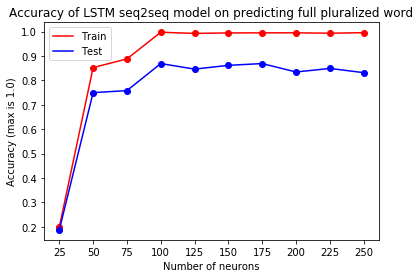

In [53]:
train_acc = [0.1986868686868687,
 0.8527272727272728,
 0.8881818181818182,
 0.9974747474747475,
 0.9927272727272727,
 0.9947474747474747,
 0.9949494949494949,
 0.9951515151515151,
 0.9935353535353535,
 0.9956565656565657]

test_acc = [ 0.18727273,  0.75      ,  0.75818182,  0.86909091,  0.84636364,
    0.86181818,  0.86909091,  0.83454545,  0.84909091,  0.83181818]

plt.plot(range(1, 11), train_acc, 'r', label="Train")
plt.plot(range(1, 11), train_acc, 'ro')

plt.plot(range(1, 11), test_acc, 'b', label="Test")
plt.plot(range(1, 11), test_acc, 'bo')

characters = [str(i*25) for i in range(1, 11)]
plt.xticks(range(1, 11), characters)
plt.xlabel('Number of neurons')
plt.ylabel('Accuracy (max is 1.0)')
plt.legend()

plt.title('Accuracy of LSTM seq2seq model on predicting full pluralized word')

In [38]:
train_acc = [0.9758585858585859,
 0.9744444444444444,
 0.9785858585858586,
 0.9708080808080808,
 0.9817171717171718,
 0.9865656565656565,
 0.9842424242424243,
 0.9891919191919192,
 0.988989898989899,
 0.9880808080808081]

In [40]:
test_acc

[0.9745454545454545,
 0.9645454545454546,
 0.9709090909090909,
 0.9709090909090909,
 0.9763636363636363,
 0.98,
 0.9818181818181818,
 0.9790909090909091,
 0.9772727272727273,
 0.980909090909091]